In [1]:
import numpy as np

In [65]:
data = np.load("data_squareRoom.npy")
print(data.shape)
# format: 22000 Bilder, ZeilenxSpaltenxRGB Channel

(22000, 70, 210, 3)


In [2]:
data = np.load("data_Lenv.npy")
print(data.shape)

(22000, 70, 210, 3)


In [56]:
data = np.load("new_more_images.npy")
print(data.shape)

(10471, 70, 210, 3)


In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(data[0]) # mitte unten ist immer bodentextur
plt.figure()
plt.imshow(data[0][:30,:100])

In [9]:
# images to video
import cv2
data_rgb = (data*255).astype(np.uint8)
height, width = data.shape[1:3]
fourcc = cv2.VideoWriter_fourcc(*'ffv1')#mp4v
video = cv2.VideoWriter("coolVideo2.mkv", fourcc, 5, (width,height))
for i,frame in enumerate(data_rgb):
    video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
video.release()

In [ ]:
from skimage import feature
from skimage.color import rgb2gray
import cv2
edges = feature.canny(rgb2gray(data[1]), sigma=2.25)
plt.figure()
plt.imshow(data[1])
plt.figure()
plt.imshow(rgb2gray(data[1]))
plt.figure()
plt.imshow(edges)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import keras

In [6]:
class Autoencoder(Model):
    def __init__(self, shape):
        super(Autoencoder, self).__init__()
        self.shape = shape
        self.encoder = tf.keras.Sequential([
            layers.Input((shape)),
            layers.Conv2D(8, (4, 4), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(16, (4, 4), activation="relu", padding="same"),
            #layers.Conv2D(32, (4, 4), activation="relu", padding="same"),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dense(4),
            layers.Dropout(0.5)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(64, activation='relu'),
            layers.Dense(35*105*32 , activation='relu'),
            layers.Reshape((35, 105, 32)),
            layers.Conv2DTranspose(8, (4, 4), activation='relu', padding="same"),
            layers.Conv2DTranspose(16, (4, 4), activation='relu', padding="same"),
            layers.UpSampling2D((2,2)),
            #layers.Conv2DTranspose(32, (4, 4), activation='relu', padding="same"),
            layers.Conv2DTranspose(3, (4, 4), activation='sigmoid', padding="same")
        ])

    def call(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)
  
    def vae_loss(self, x, x_reconstructed, mu, log_var):
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1))
        return tf.reduce_mean(kl_loss)

    def torus_loss(self, x, x_reconstructed):#, mu, log_var):
        #loss = tf.square(1-tf.square(mu[0])+tf.square(mu[1]))
        encoded = self.encoder(x)
        loss = tf.square(1-tf.square(encoded[:,0])+tf.square(encoded[:,1]))
        return tf.reduce_mean(loss)/10000
    def correlation_loss(self, x, x_reconstructed):
        encoded = self.encoder(x)
        correlation_matrix = tf.matmul(encoded[:,:2], encoded[:,2:], transpose_a=True)
        orthogonality_loss = tf.reduce_mean(tf.abs(correlation_matrix))
        return orthogonality_loss/10000
    
    def reconstruction_loss(self, y_true, y_pred):
        return tf.reduce_mean(losses.MeanSquaredError()(y_true, y_pred))

In [12]:
x_train, x_test = data,data#train_test_split(data, test_size=0.05, random_state=177013)
print(x_train.shape, x_test.shape)

(22000, 70, 210, 3) (22000, 70, 210, 3)


In [15]:
shape = x_test.shape[1:]
autoencoder = Autoencoder(shape)
autoencoder.compile(optimizer='adam', metrics=[autoencoder.reconstruction_loss, autoencoder.torus_loss, autoencoder.correlation_loss], 
                    loss="mse")#lambda x, y: autoencoder.reconstruction_loss(x,y)+autoencoder.torus_loss(x,y))
history = autoencoder.fit(x_train, x_train,
                epochs=2,
                shuffle=True)

Epoch 1/2
688/688 ━━━━━━━━━━━━━━━━━━━━ 65s 79ms/step - correlation_loss: 0.1873 - loss: 0.0136 - reconstruction_loss: 0.0136 - torus_loss: 3.8228
Epoch 2/2
688/688 ━━━━━━━━━━━━━━━━━━━━ 55s 80ms/step - correlation_loss: 0.0357 - loss: 0.0077 - reconstruction_loss: 0.0077 - torus_loss: 0.3304


In [19]:
history = autoencoder.fit(x_train, x_train,
                epochs=1,
                shuffle=True)

688/688 ━━━━━━━━━━━━━━━━━━━━ 55s 79ms/step - correlation_loss: 0.0304 - loss: 0.0069 - reconstruction_loss: 0.0069 - torus_loss: 0.2859


In [ ]:
import visualkeras
visualkeras.layered_view(autoencoder.encoder, to_file="encoder.png")
visualkeras.layered_view(autoencoder.decoder, to_file="decoder.png")

In [9]:
test_losses = autoencoder.evaluate(x_test, x_test)
print(test_losses)

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - correlation_loss: 0.0013 - loss: 0.0078 - reconstruction_loss: 0.0077 - torus_loss: 6.8550e-05
[0.007628300227224827, 0.007543826941400766, 6.891524390084669e-05, 0.0013008670648559928]


In [11]:
autoencoder.save("coolModel.keras")
autoencoder.save_weights("coolModel.weights.h5")

In [ ]:
fig, axs = plt.subplots(len(history.history.keys()))
fig.set_size_inches((5,5*len(history.history.keys())))
for i, key in enumerate(history.history.keys()):
    axs[i].plot( range(1, len(history.history[key]) + 1), history.history[key], 'o-')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel("Loss")
    axs[i].set_title(str(key))
    axs[i].grid()
plt.tight_layout()
plt.show()

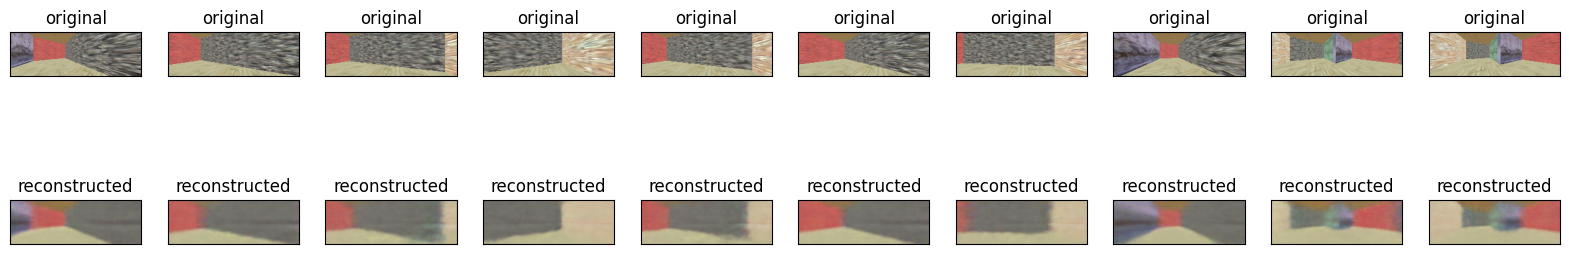

In [26]:
normal_imgs = x_test[:100][2:]
decoded_imgs = autoencoder(normal_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(normal_imgs[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [37]:
# images to video
import cv2
data_rgb = (data*255).astype(np.uint8)
height, width = data.shape[1:3]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
video = cv2.VideoWriter("coolVideoData.mp4", fourcc, 5, (width,height))
font = cv2.QT_FONT_NORMAL
for i,frame in enumerate(data_rgb[:1000]):
    encode = autoencoder.encoder(data[i].reshape(1,70,210,3))
    decode = np.array(autoencoder.decoder(np.array(encode).reshape(1,3)))
    frame = decode.reshape(70,210,3)
    frame = (frame*255).astype(np.uint8)
    frame = cv2.cvtColor(frame.copy(), cv2.COLOR_RGB2BGR)
    if i%200==0:
        print(i)
    for val in range(3):
        cv2.putText(frame, f"{encode[0][val]}", (0,10*val+10), font, .5, (0,1,0),1,cv2.LINE_AA)
    video.write(frame)
video.release()

0
200
400
600
800


In [75]:
all_encode = autoencoder.encoder(data)
np.save("all_encodings.npy", all_encode)

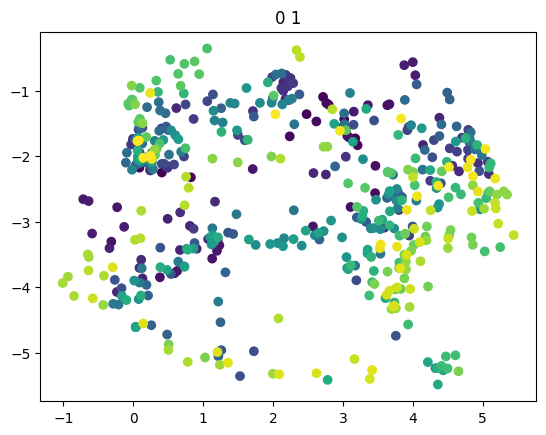

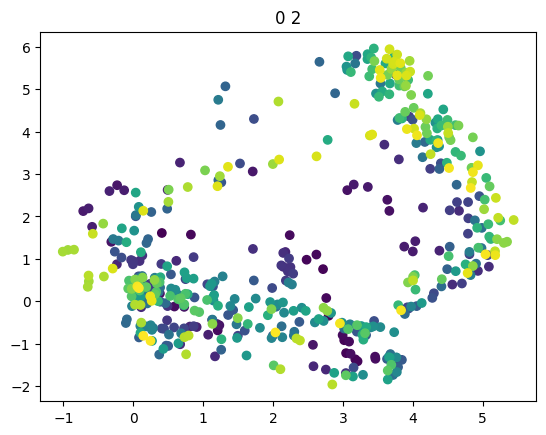

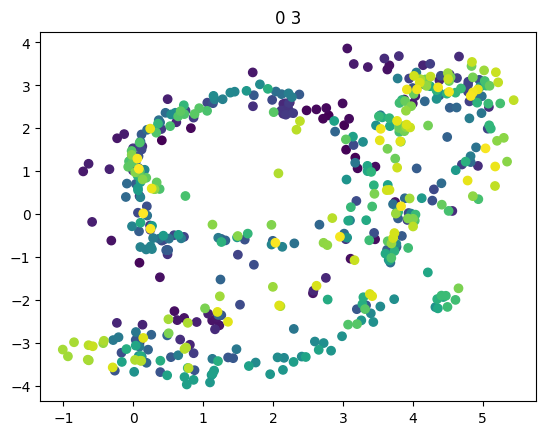

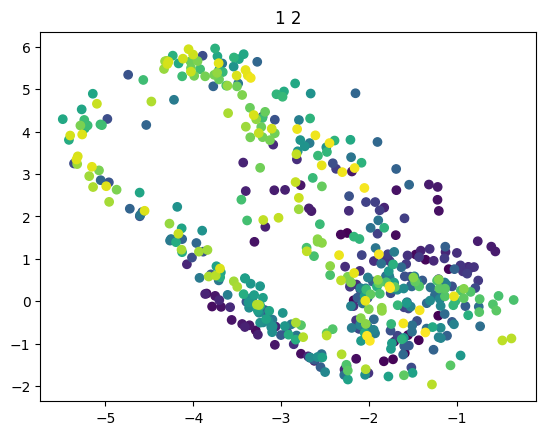

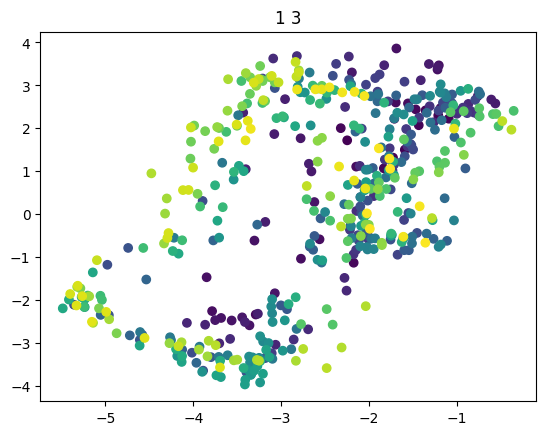

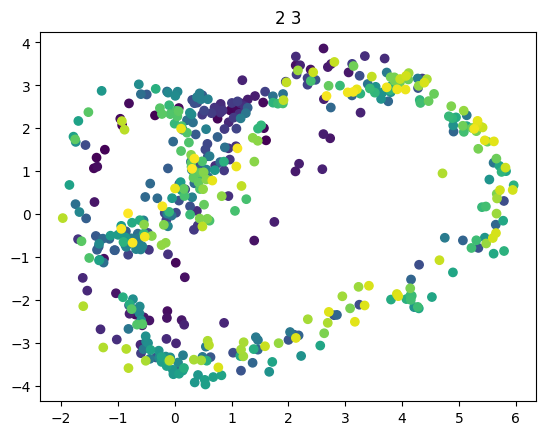

In [76]:
zoom = all_encode[:500]
gradient = np.linspace(0, 1, zoom.shape[0])
for i in range(4):
    for j in range(4):
        if i >= j: 
            continue
        plt.figure()
        #plt.xlim((-8,8))
        #plt.ylim((-8,8))
        plt.title(f"{i} {j}")
        plt.scatter(zoom[:,i], zoom[:,j], cmap="viridis", c=gradient)

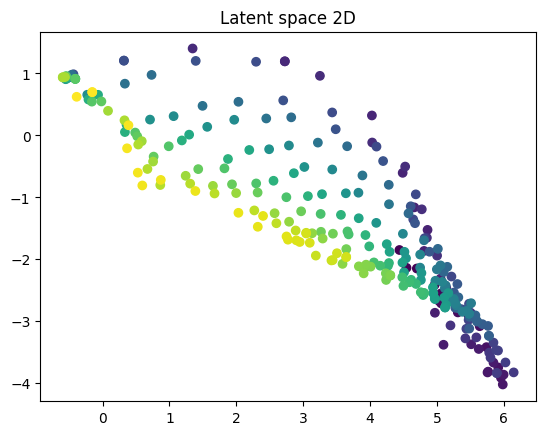

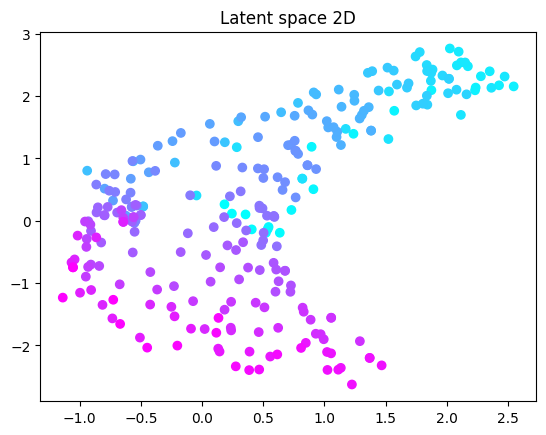

In [89]:
gradient = np.linspace(0, 1, image_encode.shape[0])
plt.title("Latent space 2D")
plt.scatter(image_encode[:,0], image_encode[:,1], cmap="viridis", c=gradient)
plt.figure()
plt.title("Latent space 2D")
plt.scatter(image_encode[:,2], image_encode[:,3], cmap="cool", c=gradient)

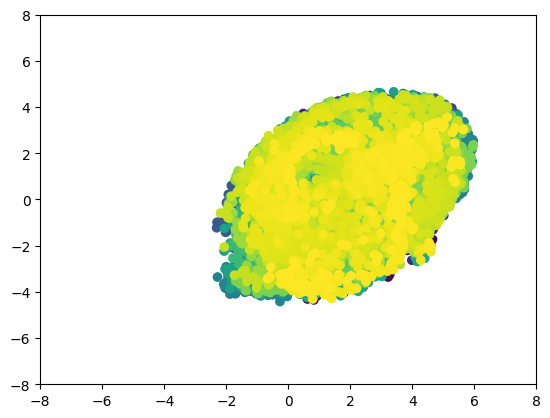

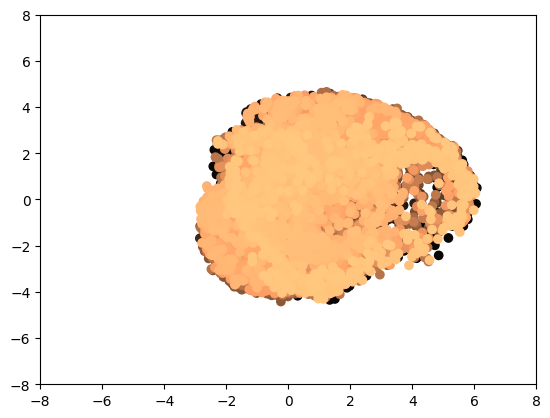

In [90]:
gradient = np.linspace(0, 1, all_encode.shape[0])
plt.xlim((-8,8))
plt.ylim((-8,8))
plt.scatter(all_encode[:,0], all_encode[:,3], cmap="viridis", c=gradient)
plt.figure()
plt.xlim((-8,8))
plt.ylim((-8,8))
plt.scatter(all_encode[:,2], all_encode[:,3], cmap="copper", c=gradient)

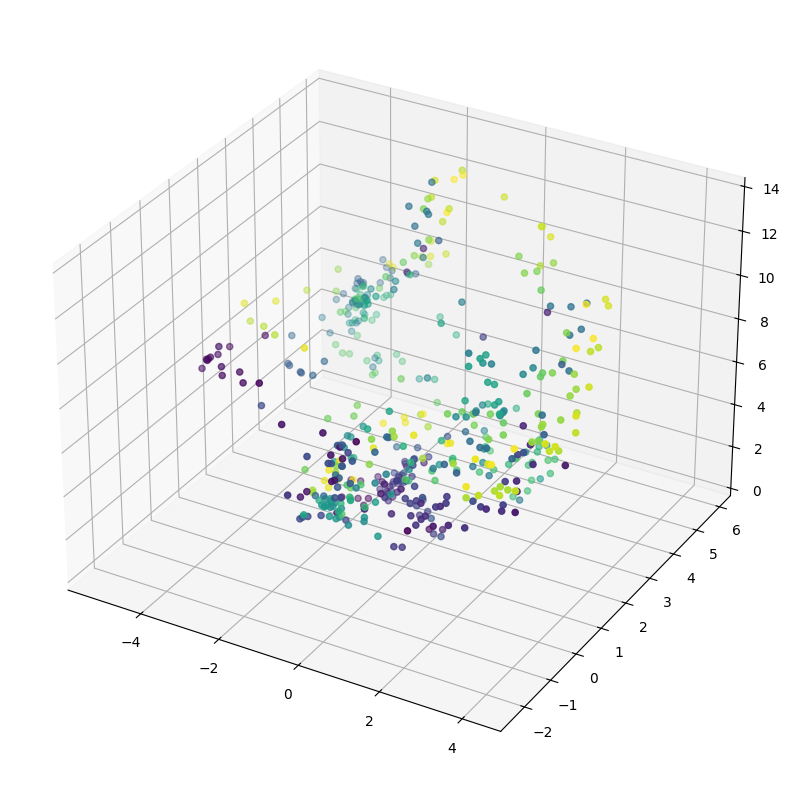

In [130]:
import matplotlib.pyplot as plt
zoom = all_encode[:500]

gradient = np.linspace(0, 1, zoom.shape[0])
fig = plt.figure(figsize = (10,10))
ax = plt.axes(projection='3d')
ax.scatter(zoom[:,1],zoom[:,0],zoom[:,2], cmap="viridis", c=gradient)
plt.show()

In [72]:
import numpy as np
data_images = np.load("degree_images2.npy")
print(data_images.shape)
image_encode = autoencoder.encoder(data_images)
print(image_encode.shape)
np.save("degree_encodings2.npy", image_encode)

(360, 70, 210, 3)
(360, 4)


In [29]:
import numpy as np
data_images = np.load("degree_images_L.npy")
print(data_images.shape)
image_encode = autoencoder.encoder(data_images)
print(image_encode.shape)
np.save("degree_encodings_L.npy", image_encode)

(360, 70, 210, 3)
(360, 4)


In [71]:
data_images = np.load("path_0_images.npy")
print(data_images.shape)
image_encode = autoencoder.encoder(data_images)
print(image_encode.shape)
np.save("path_0_encodings.npy", image_encode)

(156, 70, 210, 3)
(156, 4)


In [27]:
data_images = np.load("room_scan_L.npy")
print(data_images.shape)
image_encode = autoencoder.encoder(data_images)
print(image_encode.shape)
np.save("room_scan_L_encodings.npy", image_encode)

(360, 70, 210, 3)
(360, 4)


In [31]:
data_images = np.load("room_scan_L_90deg.npy")
print(data_images.shape)
image_encode = autoencoder.encoder(data_images)
print(image_encode.shape)
np.save("room_scan_L_90deg_encodings.npy", image_encode)

(360, 70, 210, 3)
(360, 4)


In [87]:
data_images = np.load("room_scan_images_90deg.npy")
print(data_images.shape)
image_encode = autoencoder.encoder(data_images)
print(image_encode.shape)
np.save("room_scan_encodings_90deg.npy", image_encode)

(271, 70, 210, 3)
(271, 4)


In [74]:
data_images = np.load("path_L.npy")
print(data_images.shape)
image_encode = autoencoder.encoder(data_images)
print(image_encode.shape)
np.save("path_encodings_L.npy", image_encode)

(159, 70, 210, 3)
(159, 4)


In [51]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Activation, Concatenate

def sin_activation(x):
    return tf.sin(x)
def asin_activation(x):
    return tf.asin(x)

class PeriodicAutoencoderModel(Model):
    def __init__(self):
        super(PeriodicAutoencoderModel, self).__init__()

        self.convLayer = tf.keras.Sequential([
            layers.Conv2D(8, (4, 4), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(16, (3, 3), activation="relu", padding="same"),
            layers.Flatten(),
            #layers.Dense(latent_dim, activation='relu')
        ])

        self.periodicLayer = tf.keras.Sequential([
            layers.Dense(32),
            Activation(sin_activation),
            layers.Dense(2, activation="relu")
        ])
        self.nonPeriodicLayer = tf.keras.Sequential([
            layers.Dense(32, activation="relu"),
            layers.Dense(2, activation="relu")
        ])

        self.concat = Concatenate()
        self.dropout = layers.Dropout(0.5)

        self.periodicDecoderLayer = tf.keras.Sequential([
            layers.Dense(32),
            Activation(asin_activation),
            layers.Dense(35* 105* 3//2, activation="relu"),
        ])
        self.nonPeriodicDecoderLayer = tf.keras.Sequential([
            layers.Dense(32, activation='relu'),
            layers.Dense(35* 105* 3//2, activation="relu")
        ])
        self.convDecoderLayer = tf.keras.Sequential([
            layers.Dense(35* 105* 3, activation="relu"),
            layers.Reshape((35, 105, 3)),
            layers.Conv2DTranspose(16, (3, 3), activation='relu', padding="same"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(3, (4, 4), activation='sigmoid', padding="same")
        ])

        """self.decoder = tf.keras.Sequential([
            layers.Dense(35*105*3 , activation=Activation(sin_activation)),
            layers.Reshape((35, 105, 3)),
            layers.Conv2DTranspose(16, (3, 3), activation='relu', padding="same"),
            layers.UpSampling2D((2,2)),
            layers.Conv2DTranspose(3, (4, 4), activation='sigmoid', padding="same")
        ])"""

    def call(self, inputs):
        x = self.convLayer(inputs)

        x_periodic = self.periodicLayer(x)
        x_non_periodic = self.nonPeriodicLayer(x)

        latent_space = tf.concat([x_periodic, x_non_periodic], axis=-1)

        latent_space = self.dropout(latent_space)

        latent_periodic, latent_non_periodic = tf.split(latent_space, num_or_size_splits=2, axis=-1)
        y_periodic = self.periodicDecoderLayer(latent_periodic)
        y_non_periodic = self.nonPeriodicDecoderLayer(latent_non_periodic)
        
        decoder_conv_in = self.concat([y_periodic, y_non_periodic])
        decoded = self.convDecoderLayer(decoder_conv_in)

        return decoded

    def encoder(self, inputs):
        """x = Input(shape=(70, 210, 3))
        return Model(inputs=x, outputs=self.concat([self.periodicLayer(self.convLayer(x)), self.nonPeriodicLayer(self.convLayer(x))]))
        """
        x = self.convLayer(inputs)

        x_periodic = self.periodicLayer(x)
        x_non_periodic = self.nonPeriodicLayer(x)
        latent_space = tf.concat([x_periodic, x_non_periodic], axis=-1)
        return latent_space
    def decoder(self, encoded):
        x_periodic, x_non_periodic = encoded

        y_periodic = self.periodicDecoderLayer(x_periodic).numpy()
        y_non_periodic = self.nonPeriodicDecoderLayer(x_non_periodic).numpy()
        decoder_conv_in = self.concat([y_periodic, y_non_periodic])
        decoded = self.convDecoderLayer(decoder_conv_in)
        return decoded
    
def torus_regularization(encoded):
    # Regularization term for torus topology in 3D latent space
    #p1, p2, p3 = tf.split(encoded, num_or_size_splits=3, axis=-1)
    diffClamp = tf.square(encoded - tf.math.floormod(encoded, 1.0))
    return tf.reduce_sum(diffClamp, axis=-1)

def custom_loss(y_true, y_pred):
    reconstruction_loss = losses.MeanSquaredError()(y_true, y_pred)
    x_periodic, x_non_periodic = autoencoder.encoder()(y_true)
    regularization_loss = tf.reduce_mean(torus_regularization(x_periodic))
    return reconstruction_loss + regularization_loss

# Autoencoder-Modell initialisieren
autoencoder = PeriodicAutoencoderModel()

# Modell kompilieren
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=["accuracy"])

shape = x_test.shape[1:]
history = autoencoder.fit(x_train, x_train,
                epochs=1,
                shuffle=True)

295/295 ━━━━━━━━━━━━━━━━━━━━ 139s 462ms/step - accuracy: 0.5895 - loss: 0.0195


In [54]:
encoded_imgs = autoencoder.encoder(x_test)
print(encoded_imgs)
decoded_imgs = autoencoder.decoder(encoded_imgs)
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

tf.Tensor(
[[nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]
 ...
 [nan nan nan nan]
 [nan nan nan nan]
 [nan nan nan nan]], shape=(1048, 4), dtype=float32)


ValueError: too many values to unpack (expected 2)

In [4]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D


base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(70, 210, 3))

# Extract features from a specific layer
x = base_model.get_layer("conv5_block3_out").output
x = GlobalAveragePooling2D()(x)
feature_extractor = Model(inputs=base_model.input, outputs=x)